In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from utils import *
from deconv import *

In [2]:
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

## Example Bipolar Data (2021_05_12 v2)
### In each table:                                                             
- All 200um static spot stimuli.
- DD and PD CSVs are organized as pairs of trials (just two each) for each ROI.
- e.g. roi0_t0 | roi0_t1 | ... | roiN_t1
- (original name: DD_20210512_scan6_200um.csv)

### Specs
- **ROI Size:** 10um
- **Scan rate for all:** 58.25 Hz

In [3]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_05_12_v2/waveforms/")
n_trials = 2
hz = 58.25
dt = 1 / hz

recs = {}
for d in ["DD", "PD"]:
    vals = pd.read_csv(os.path.join(data_path, d) + ".csv", skiprows=1).values.T
    recs[d] = vals.reshape(vals.shape[0] // n_trials, n_trials, -1)

normed = {d: rs / np.max(rs, axis=2, keepdims=True) for d, rs in recs.items()}
avg_recs = {d: np.mean(rs, axis=1) for d, rs in recs.items()}
avg_normed = {d: rs / np.max(rs, axis=1, keepdims=True) for d, rs in avg_recs.items()}

aligned_recs = {d: aligned_avg(rs) for d, rs in avg_recs.items()}
aligned_normed = {d: rs / np.max(rs) for d, rs in aligned_recs.items()}

_, _, n_pts = recs["DD"].shape # number of points is the same across fields
rec_xaxis = np.arange(n_pts) * dt
print("DD Shape (n_rois, n_trials, n_pts):", recs["DD"].shape)
print("PD Shape (n_rois, n_trials, n_pts):", recs["PD"].shape)

DD Shape (n_rois, n_trials, n_pts): (9, 2, 449)
PD Shape (n_rois, n_trials, n_pts): (7, 2, 449)


### Data Overview (plots of all ROIs for both scan-fields)

<IPython.core.display.Javascript object>


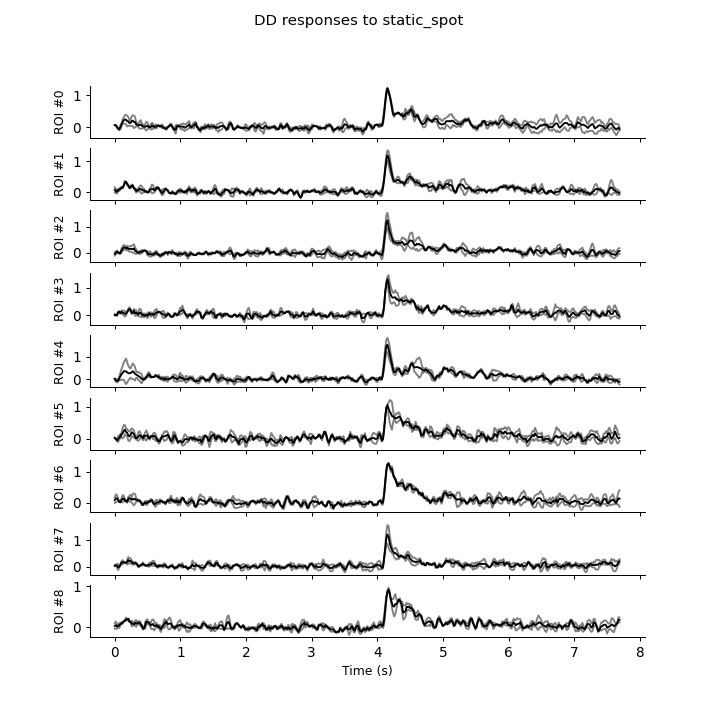

<IPython.core.display.Javascript object>


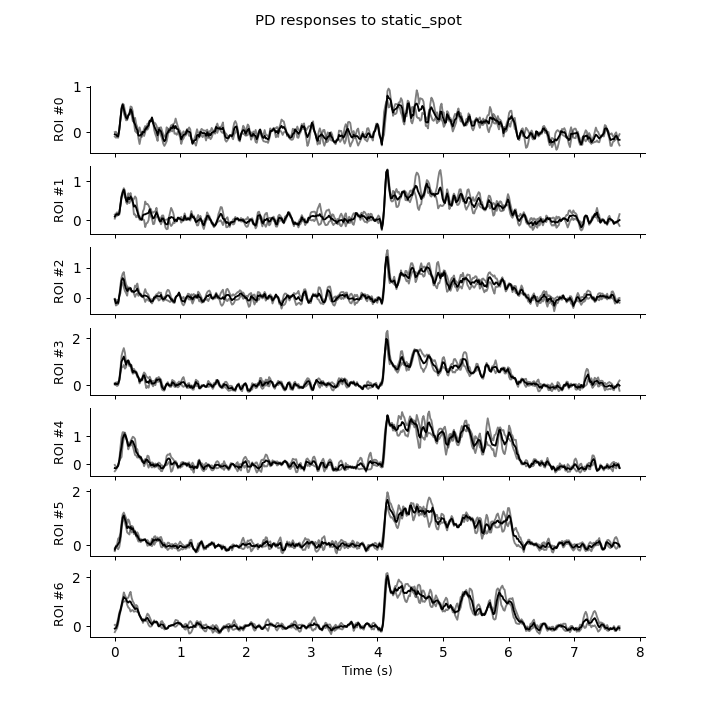

In [4]:
rec_figures = {}
for depth, rois in recs.items():
    rec_figures[depth] = {}
    rec_figures[depth]["fig"], rec_figures[depth]["ax"] = plt.subplots(
        len(rois), sharex=True, figsize=(8, 8)
    )
    for i, trials in enumerate(rois):
        for tr in trials:
            rec_figures[depth]["ax"][i].plot(rec_xaxis, tr, c="black", alpha=0.5)

        av = np.mean(trials, axis=0)
        rec_figures[depth]["ax"][i].plot(rec_xaxis, av, c="black")
        rec_figures[depth]["ax"][i].set_ylabel("ROI #%i" % i)
        clean_axes(rec_figures[depth]["ax"][i])

        rec_figures[depth]["fig"].suptitle("%s responses to static_spot" % depth)
        rec_figures[depth]["ax"][-1].set_xlabel("Time (s)")
        rec_figures[depth]["fig"].show()

<IPython.core.display.Javascript object>


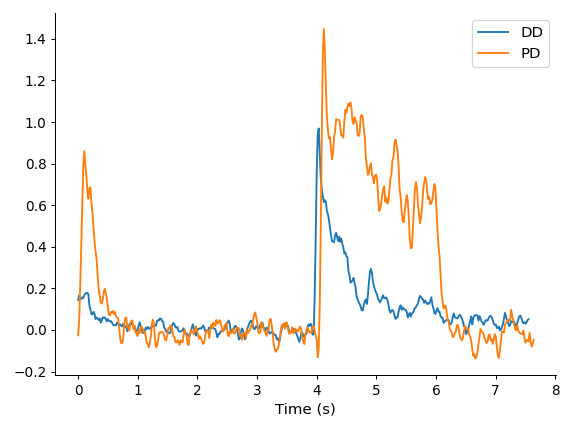

In [5]:
aligned_fig, aligned_ax = plt.subplots(1)
for depth, avg in aligned_recs.items():
    aligned_ax.plot(np.arange(len(avg)) * dt, avg, label=depth)

clean_axes(aligned_ax)
aligned_ax.set_xlabel("Time (s)", fontsize=12)
aligned_ax.legend(fontsize=12)
aligned_fig.tight_layout()
aligned_fig.show()

### QSE estimation from static spot responses in the proximal scan field
- steady state QSEs calculated with the relatively flat section of the responses (with the exception of the moving spot which has no such region
- base QSEs calculated from a stable window of the baseline preceding the response

In [6]:
windows = {"base": {0: 1.5, 1: 3.5}, "steady": {0: 5., 1: 6.}}

qses, avg_qses = [{"steady": [], "base": []} for _ in range(2)]
steady_start = nearest_index(rec_xaxis, windows["steady"][0])
steady_stop = nearest_index(rec_xaxis, windows["steady"][1])
base_start = nearest_index(rec_xaxis, windows["base"][0])
base_stop = nearest_index(rec_xaxis, windows["base"][1])

for trials in recs["PD"]:
    for tr in trials:
        qses["steady"].append(quantal_size_estimate(tr[steady_start:steady_stop]))
        qses["base"].append(quantal_size_estimate(tr[base_start:base_stop]))
    
    av = np.mean(trials, axis=0)
    avg_qses["steady"].append(quantal_size_estimate(av[steady_start:steady_stop]))
    avg_qses["base"].append(quantal_size_estimate(av[base_start:base_stop]))
    
print("Quantal Size Estimates for static spot:")
for k in windows.keys():
    qses[k] = np.array(qses[k])
    avg_qses[k] = np.array(avg_qses[k])
    print("  period:", k)
    print("    per-trial:", np.round(qses[k], decimals=3)) 
    print("      mean: %.3f" % np.mean(qses[k]))
    print("    averaged trials:", np.round(avg_qses[k], decimals=3))
    print("      mean: %.3f" % np.mean(avg_qses[k]))
    print("")

Quantal Size Estimates for static spot:
  period: base
    per-trial: [ -2.294  -0.67    2.232 -14.533  -4.539   1.978   2.106  -2.728  -2.629
  -0.786   5.409  -1.832  -2.185  -0.493]
      mean: -1.497
    averaged trials: [-0.689  2.124  2.86  38.412 -0.56  -2.299 -0.33 ]
      mean: 5.645

  period: steady
    per-trial: [0.103 0.12  0.072 0.136 0.13  0.086 0.153 0.121 0.212 0.201 0.106 0.102
 0.325 0.218]
      mean: 0.149
    averaged trials: [0.061 0.052 0.051 0.084 0.109 0.05  0.179]
      mean: 0.084



### Generate representative biexponential quantal event
Rough representation of an iGluSnFr mini from a bipolar terminal

using qse = 0.14890


<IPython.core.display.Javascript object>


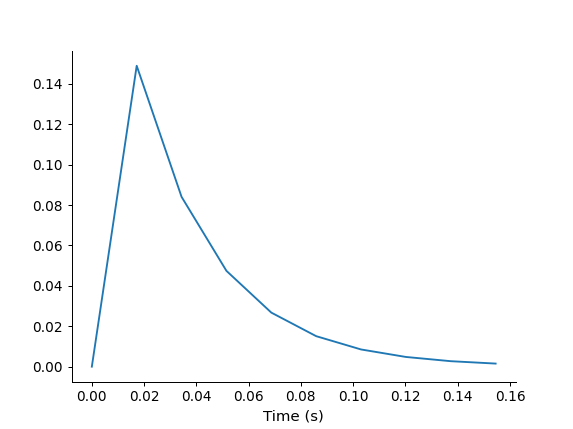

In [7]:
tau1 = 2 # rise [ms]
tau2 = 30  # decay [ms]
quantum_pts = 10

fitter = BiexpFitter(1, 10, norm_amp=True)
biexp_quantum = fitter.model(
    t=np.arange(quantum_pts), 
    tau1=tau1 / 1000 / dt, # convert to match resulting sample-rate to data
    tau2=tau2 / 1000 / dt, 
    y0=1.,
)[0]
biexp_xaxis = np.arange(quantum_pts) * dt

qse = np.mean(qses["steady"])
qse_quantum = biexp_quantum * qse
print("using qse = %.5f" % qse)

biexp_fig, biexp_ax = plt.subplots(1)
biexp_ax.plot(biexp_xaxis, qse_quantum)
biexp_ax.set_xlabel("Time (s)", fontsize=12)
clean_axes(biexp_ax)
biexp_fig.savefig(os.path.join(data_path, "qse_quantum.svg"), bbox_inches="tight")
biexp_fig.show()

### Run through quantal analysis with example waveform

In [8]:
depth = "PD"
roi_idx = 0
trial_idx = 0
ev = normed[depth][roi_idx, trial_idx]
quantum_fft = np.fft.rfft(qse_quantum, n=len(ev))
rec_fft = np.fft.rfft(ev)
inv = np.fft.irfft(rec_fft / quantum_fft)
deconv = np.convolve(inv, qse_quantum)

bin_t = 0.05  # st
# bin_t = dt  # s
sz = int(bin_t / dt)
bin_edges = np.arange(sz, len(inv) + sz, sz) * dt
binned = bin_mean(inv, sz)
print("points per bin:", sz)
print("time per bin: %.2fms" % (sz * dt * 1000))

scale_mode = False
ceiling = 0.95
max_q = 5
q_scale = 1. / max_q if scale_mode else 1.

quanta = raster(binned, thresh=np.max(binned) * ceiling / max_q, max_q=max_q)    
quantal_sum = sum_quanta(quanta, bin_edges, qse_quantum * q_scale, dt)
quantal_sum_xaxis = np.arange(len(quantal_sum)) * dt

points per bin: 2
time per bin: 34.33ms


<IPython.core.display.Javascript object>


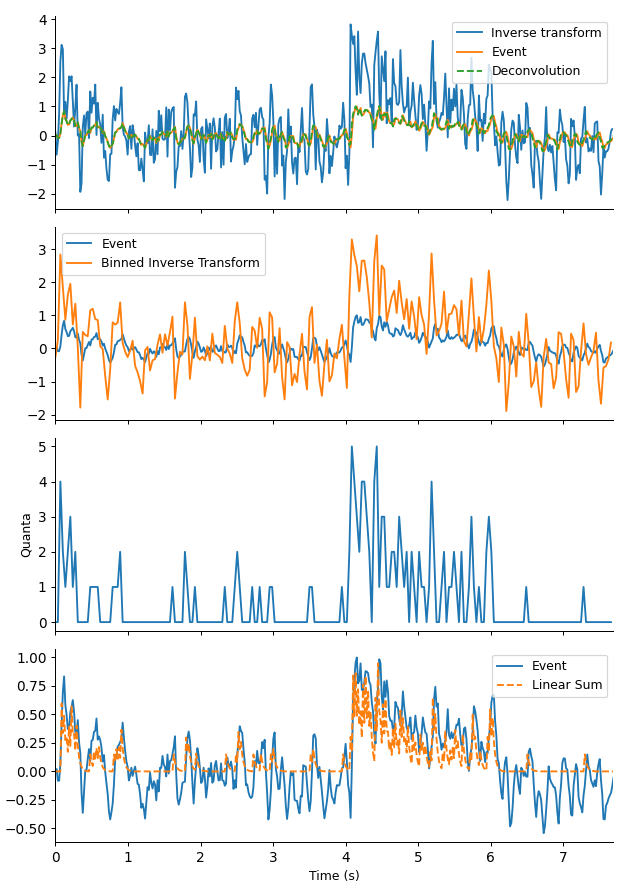

In [9]:
ex_quanta_fig, ex_quanta_ax = plt.subplots(4, sharex=True,figsize=(7, 10))

ex_quanta_ax[0].plot(rec_xaxis[:-1], inv, label="Inverse transform")
ex_quanta_ax[0].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[0].plot(np.arange(len(deconv)) * dt, deconv, label="Deconvolution", linestyle="--")
ex_quanta_ax[0].legend()

ex_quanta_ax[1].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[1].plot(bin_edges, binned, label="Binned Inverse Transform")
ex_quanta_ax[1].legend()

ex_quanta_ax[2].plot(bin_edges, quanta)
ex_quanta_ax[2].set_ylabel("Quanta")

ex_quanta_ax[3].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[3].plot(quantal_sum_xaxis, quantal_sum, label="Linear Sum", linestyle="--")
ex_quanta_ax[3].set_xlim(0, np.max(rec_xaxis))
ex_quanta_ax[3].legend()
ex_quanta_ax[3].set_xlabel("Time (s)")

for ax in ex_quanta_ax:
    clean_axes(ax)

ex_quanta_fig.tight_layout()
ex_quanta_fig.show()

### Run quantal analysis on all recordings
- All trials, of all ROIs, from both proximal and distal scan fields
- Run through with a range of maximum quanta count (`max_q`) values

In [10]:
def quantify(data, bin_t=0.05, ceiling=0.95, max_q=5, scale_mode=False):
    res = {}
    for depth, rois in data.items():
        res[depth] = {}
        (
            res[depth]["quanta"], 
            res[depth]["quanta_xaxis"], 
            res[depth]["quantal_sum"],
            res[depth]["quantal_sum_xaxis"],
        ) = get_quanta(
                rois, 
                qse_quantum, 
                dt, 
                bin_t=bin_t,
                ceiling=ceiling,
                max_q=max_q,
                scale_mode=scale_mode
            )
    return res

quantifications = {i: quantify(recs, max_q=i, scale_mode=False) for i in range(1, 15)}
aligned_quants = {i: quantify(aligned_recs, max_q=i, scale_mode=False) for i in range(1, 15)}

### Calculate Mean Squared Error to see how the quantal sums fit to the original data depends on the maximum number of quanta per time bin

<IPython.core.display.Javascript object>


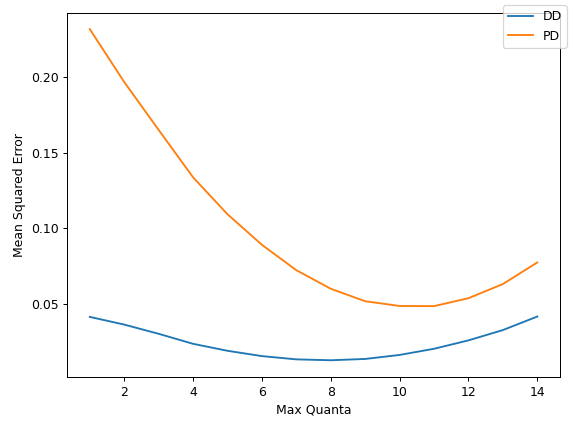

In [11]:
mses = {d: [] for d in ["DD", "PD"]}
for n, data in quantifications.items():
    for depth, quants in data.items():
        r = recs[depth]
        diff = r - quants["quantal_sum"][:, :, :r.shape[-1]]  # truncate to same shape
        mses[depth].append(np.mean(diff ** 2))

mse_xaxis = np.array(list(quantifications.keys()))
mses = {d: np.array(rois) for d, rois in mses.items()}

mse_fig, mse_ax = plt.subplots(1)
for i, (depth, errors) in enumerate(mses.items()):
    mse_ax.plot(mse_xaxis, errors, label=depth)
    
mse_ax.set_ylabel("Mean Squared Error")
mse_ax.set_xlabel("Max Quanta")
clean_axes(ax)
mse_fig.legend()
mse_fig.tight_layout()
mse_fig.show()

<IPython.core.display.Javascript object>


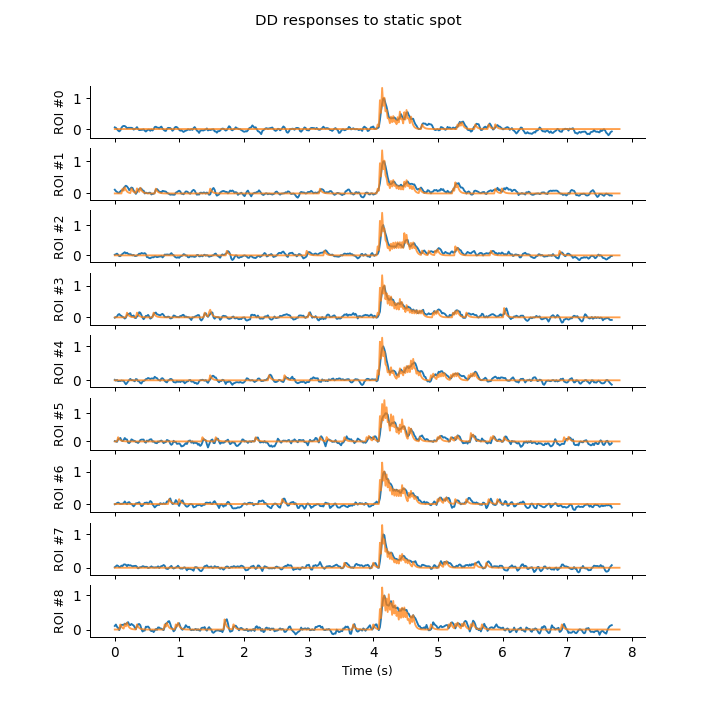

<IPython.core.display.Javascript object>


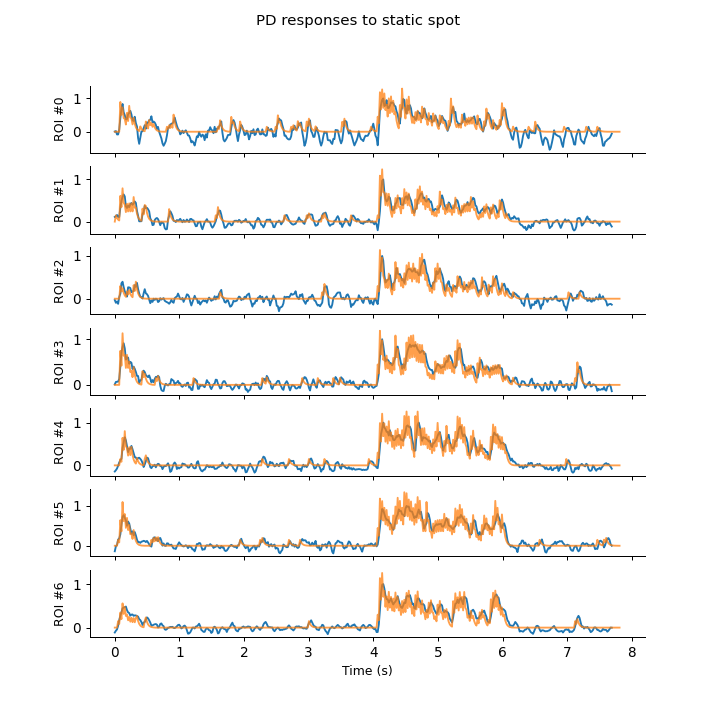

In [20]:
max_q = 7
trial_idx = 0
quants = quantifications[max_q]

quanta_figures = {}
for depth in normed.keys():
    quanta_figures[depth] = {}
    quanta_figures[depth]["fig"], quanta_figures[depth]["ax"] = plt.subplots(
        normed[depth].shape[0], sharex=True, figsize=(8, 8)
    )
    if trial_idx is None:
        rois = np.mean(normed[depth], axis=1)
        qsums = np.mean(normed[depth]["quantal_sum"], axis=1)
    else:
        rois = normed[depth][:, trial_idx]
        qsums = quants[depth]["quantal_sum"][:, trial_idx]
    for i, (roi, qsum) in enumerate(zip(rois, qsums)):
        quanta_figures[depth]["ax"][i].plot(
            rec_xaxis, roi, label="Event" if not i else None)
        quanta_figures[depth]["ax"][i].plot(
            quants[depth]["quantal_sum_xaxis"], 
            qsum, 
            alpha=0.75, 
            label="Quantal Sum" if not i else None
        )
        quanta_figures[depth]["ax"][i].set_ylabel("ROI #%i" % i)
        clean_axes(quanta_figures[depth]["ax"][i])

    quanta_figures[depth]["fig"].suptitle("%s responses to static spot" % depth)
    quanta_figures[depth]["ax"][-1].set_xlabel("Time (s)")
    quanta_figures[depth]["fig"].show()

<IPython.core.display.Javascript object>


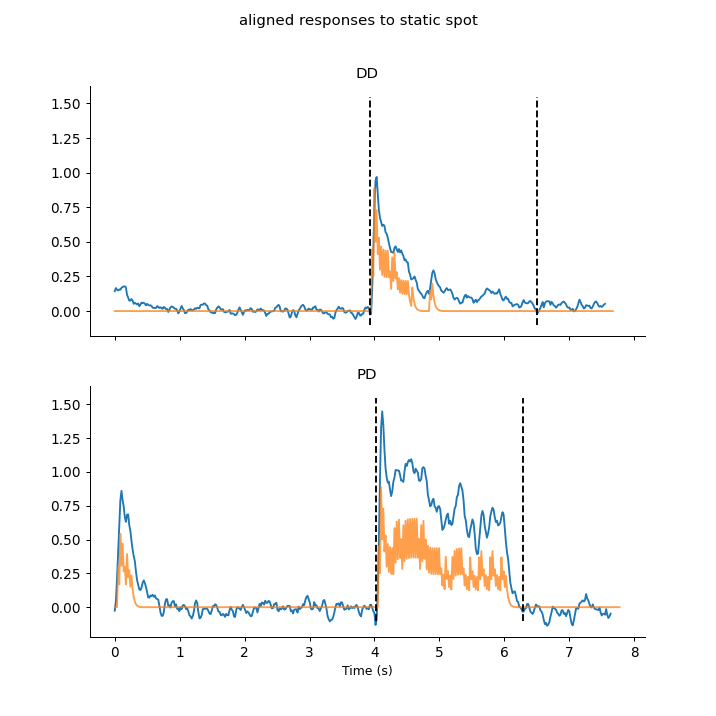

In [30]:
max_q = 5
aligned_qs = aligned_quants[max_q]
mark_ends = True
mark_peak = True

aligned_q_fig, aligned_q_ax = plt.subplots(2, sharex=True, figsize=(8, 8))
for depth, ax in zip(aligned_recs.keys(), aligned_q_ax):
    r = aligned_recs[depth]
    ax.plot(np.arange(len(r)) * dt, aligned_recs[depth], label="Event")
    ax.plot(
        aligned_qs[depth]["quantal_sum_xaxis"], 
        aligned_qs[depth]["quantal_sum"], 
        alpha=0.75, 
        label="Quantal Sum"
    )
    if mark_ends:
        rise_idx = find_rise_bsln(r, bsln_start=100, bsln_end=150, step=2)
        rise_t = rise_idx * dt
        ax.plot([rise_t, rise_t], [-0.1, np.max(avg) + 0.1], linestyle="--", c="black")
        fall_idx = find_bsln_return(r, bsln_start=100, bsln_end=150, offset=-0.01, step=5)
        fall_t = fall_idx * dt
        ax.plot([fall_t, fall_t], [-0.1, np.max(avg) + 0.1], linestyle="--", c="black")
    ax.set_title(depth)
    
clean_axes(aligned_q_ax)
aligned_q_fig.suptitle("aligned responses to static spot")
ax.set_xlabel("Time (s)")
aligned_q_fig.show()

In [36]:
aligned_rates = {
    d: np.fft.irfft(np.fft.rfft(r) / np.fft.rfft(qse_quantum, n=len(r)))
    for d, r in aligned_recs.items()
}

# TODO: clip using the length of the PD responses?
# TODO: clip using the savgol of the rate?
extra_lead = 0
extra_tail = 5
clipped_aligned_rates = {
    d: r[
        find_rise_bsln(r, bsln_start=100, bsln_end=150, step=1) - extra_lead:
        find_bsln_return(
            r, bsln_start=100, bsln_end=150, offset=-0.1, step=5) + extra_tail
        ]
    for d, r in aligned_rates.items()
}

<IPython.core.display.Javascript object>


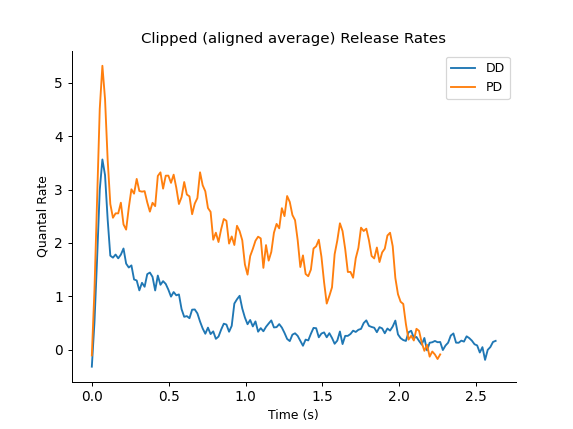

In [41]:
normalize = False
clipped_rate_fig, clipped_rate_ax = plt.subplots(1)
for depth, rate in clipped_aligned_rates.items():
    r = rate / np.max(rate) if normalize else rate 
    clipped_rate_ax.plot(np.arange(len(r)) * dt, r, label=depth)

clipped_rate_ax.legend()
clean_axes(clipped_rate_ax)

clipped_rate_ax.set_xlabel("Time (s)")
clipped_rate_ax.set_ylabel("Quantal Rate")
clipped_rate_ax.set_title("Clipped (aligned average) Release Rates")
clipped_rate_fig.show()

In [43]:
# add velocity (future rate data will include multiple velocities)
clipped_dict = {
    d: {500: {"static_spot": rate}}
    for d, rate in clipped_aligned_rates.items()
}

quanta_dict = {
    "qse": qse,
    "tau1": tau1,
    "tau2": tau2,
    "quantum": qse_quantum,
    "aligned_recs": aligned_recs,
    "clipped_rates": clipped_dict,
}
pack_hdf(os.path.join(data_path, "quantum_pack_05_12_v2"), quanta_dict)

<IPython.core.display.Javascript object>


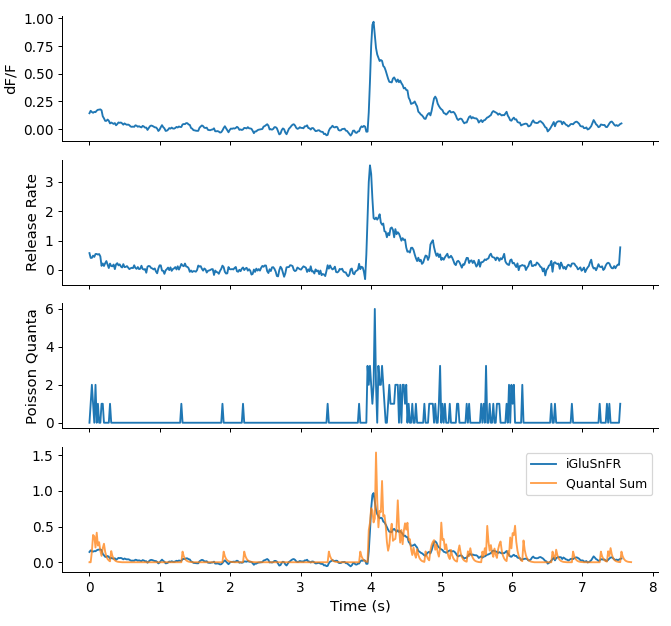

In [48]:
depth = "DD"
roi_idx = None
trial_idx = None
if roi_idx is None:
    ex = aligned_recs[depth] 
elif trial_idx is None:
    ex = avg_recs[roi_idx]
else:
    ex = recs[depth][roi_idx]

xaxis = np.arange(len(ex)) * dt
steady_start = nearest_index(xaxis, 4.74)
steady_stop = nearest_index(xaxis, 5.74)
unique_qse = quantal_size_estimate(ex[steady_start:steady_stop])
# unique_quantum = unique_qse * biexp_quantum
# unique_quantum = .5 * biexp_quantum
unique_quantum = qse_quantum
inv = np.fft.irfft(
    np.fft.rfft(ex) / np.fft.rfft(unique_quantum, n=len(ex))
)

if False:
    bin_t = 0.05  # st
    # bin_t = dt  # s
    sz = int(bin_t / dt)
    bin_edges = np.arange(sz, len(inv) + sz, sz) * dt
    binned = bin_mean(inv, sz)
    scale_mode = False
    ceiling = 0.95
    max_q = 4
    q_scale = 1. / max_q if scale_mode else 1.
    rpq = raster(binned, thresh=np.max(binned) * ceiling / max_q, max_q=max_q)    
    rpq_xaxis = np.arange(len(rpq)) * sz * dt
    rpq_sum = sum_quanta(rpq, bin_edges, unique_quantum * q_scale, dt)
    q_label = "Quanta"
else:
    rpq = poisson_of_release(inv)
    rpq_xaxis = np.arange(len(rpq)) * dt
    rpq_sum = sum_quanta(rpq, np.arange(len(rpq)) * dt, unique_quantum, dt)
    q_label = "Poisson Quanta"

rpq_sum_xaxis = np.arange(len(rpq_sum)) * dt

grant_fig, grant_ax = plt.subplots(4, sharex=True, figsize=(7.5, 7))
grant_ax[0].plot(np.arange(len(ex)) * dt, ex,)
grant_ax[0].set_ylabel("dF/F", fontsize=12)
grant_ax[1].plot(np.arange(len(inv)) * dt, inv)
grant_ax[1].set_ylabel("Release Rate", fontsize=12)
grant_ax[2].plot(rpq_xaxis, rpq)
grant_ax[2].set_ylabel(q_label, fontsize=12)
grant_ax[3].plot(np.arange(len(ex)) * dt, ex, label="iGluSnFR")
grant_ax[3].plot(rpq_sum_xaxis, rpq_sum, alpha=0.75, label="Quantal Sum")
grant_ax[3].legend(fontsize=10)
grant_ax[3].set_xlabel("Time (s)", fontsize=12)
#grant_ax[2].set_xlim(4, 6.5)
clean_axes(grant_ax)
grant_fig.tight_layout()
grant_fig.savefig(os.path.join(data_path, "poisson_quanta_ex.svg"), bbox_inches="tight")
grant_fig.show()